Challenge Set 1

Topic:        Explore MTA turnstile data

Date:         1/13/2016

Name:         Justin Stewart


# Challenge 1:

Download a few MTA turnstile data files. Open up a file, use csv reader to read it, make a python dict where there is a key for each (C/A, UNIT, SCP, STATION). These are the first four columns. The value for this key should be a list of lists. Each list in the list is the rest of the columns in a row.

In [ ]:
#!curl http://web.mta.info/developers/data/nyct/turnstile/turnstile_160109.txt > mta_data_jan09.csv

In [1]:
import csv

def mta_csv_to_dict(path_to_csv):
    with open(path_to_csv) as csvfile:
        mta_reader = csv.reader(csvfile, delimiter=',')
        mta_rows = [[cell.strip() for cell in row] for row in mta_reader]
    assert mta_rows.pop(0) == ['C/A','UNIT','SCP','STATION','LINENAME','DIVISION',
                               'DATE','TIME','DESC','ENTRIES','EXITS']
    mta_dict = {}
    for row in mta_rows:
        key, val =  tuple(row[:4]), row[4:]
        mta_dict.setdefault(key,[]).append(val)
    return mta_dict

mta_dict = mta_csv_to_dict('mta_data_jan09.csv')

# Challenge 2

Let's turn this into a time series. For each key (basically the control area, unit, device address and station of a specific turnstile), have a list again, but let the list be comprised of just the point in time and the count of entries. This basically means keeping only the date, time, and entries field in each list.

First we create a new dictionary containing the same key and change the value to a list containing the resulting datetime object found by parseing to date and time feilds, and the cummulative value of entries at that key. 

In [31]:
from dateutil.parser import parse

mta_cummulative_timeseries = {key: [[parse(row[2]+' '+row[3]),int(row[5])] 
                                      for i, row in enumerate(val)] 
                                      for key,val in mta_dict.items()}



Then we create another dictionary, again using the same keys, but find the total entries per turnstyle by taking the difference between subsequent recordings.

In [36]:
mta_timeseries = {key:[[val[i][0],
                        val[i+1][1]-val[i][1]] 
                  for i in range(len(val)-1)]
                  for key,val in mta_cummulative_timeseries.items()}

# Challenge 3

Now we create the dictionary a third time (with same keys) but now have a single value for a single day, which is the total number of passengers that entered through this turnstile on this day. These counts are for every n hours. (What is n?) We want total daily entries.

The value of n is 4 hours.

Completing this requires iterating through the items of the mta_timeseries and aggregating the values that are in the same day. Solution is given below. 

In [40]:
mta_daily_timeseries = {}
for key,time_counts in mta_timeseries.items():
    day_counts = {}
    for time,count in time_counts:
        date = time.date()
        day_counts[date] = day_counts.get(date,0) + count
    mta_daily_timeseries[key] = sorted(day_counts.items())

# Challenge 4

Plot the daily time series for a turnstile.

In [50]:
turnstyle = mta_daily_timeseries.items()[0][1]
dates,counts = zip(*turnstyle)

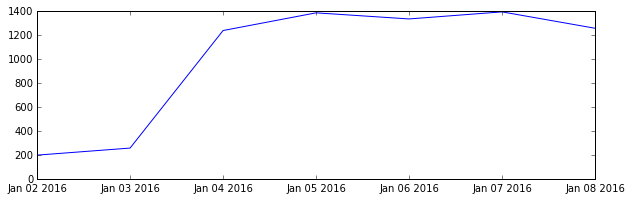

In [53]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(10,3))
plt.plot(dates,counts)

# Challenge 5

So far we've been operating on a single turnstile level, let's combine turnstiles in the same ControlArea/Unit/Station combo. There are some ControlArea/Unit/Station groups that have a single turnstile, but most have multiple turnstilea-- same value for the C/A, UNIT and STATION columns, different values for the SCP column. We want to combine the numbers together -- for each ControlArea/UNIT/STATION combo, for each day, add the counts from each turnstile belonging to that combo.

In [69]:
unit_level = {}
for key, val in mta_daily_timeseries.items():
    a,b,_,s = key
    unit_key = (a,b,s)
    unit_val = {}
    for date,count in val:
        unit_val[date] = unit_val.get(date,0) + count
    unit_level[unit_key] = sorted(unit_val.items())
